In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pickle
%matplotlib inline

from scipy.stats import randint, uniform

from functions import evaluate_model, runtime, optimal_parameters
from preprocessor_class import Preprocessor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Data/prepared_text_data_sugar.csv')

#### Preprocessing and Vectorizing Text

The process for preprocessing can be found in the preprocessor_class.py file in the repo.  I chose to use stemming instead of lemmatization because there isn't much sentence structure within the data and most of the words aren't following traditional grammar structures.  After pre-processing, I used TF-IDF Vectorizer to transform the data.  TF-IDF was used due to the imbalance of frequency of word tokens amonget the documents.

In [3]:
start = time.time()

X = df['text']
y = df['sugar_class']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)
processor = Preprocessor()
X_train_transformed = processor.fit_transform(X_train_raw)
X_test_transformed = processor.transform(X_test_raw)

vector_pipe = Pipeline([('tfidf', TfidfVectorizer())])
X_train_vector = vector_pipe.fit_transform(X_train_transformed)
X_test_vector = vector_pipe.transform(X_test_transformed)
X_train = pd.DataFrame(X_train_vector.toarray(), columns = vector_pipe['tfidf'].get_feature_names())
X_test = pd.DataFrame(X_test_vector.toarray(), columns = vector_pipe['tfidf'].get_feature_names())

end = time.time()
runtime(start, end)

Runtime: 28.59 seconds


#### Naive-Bayes

The first model I tested was Naive-Bayes.  Naive-Bayes models are simplistic and quick and I was mostly interested in making sure the data was processed in a way such that even a simple model would be able to make predictions.  These models were not going to be the most accurate since they fail to capture the complexity in the text.  Most importantly, they also assume independence of all the features which is impractical when most chain restaurants each have their own naming conventions and commonly used words in their descriptions.

In [4]:
start = time.time()

multinb = MultinomialNB()
multinb.fit(X_train, y_train)
evaluate_model(multinb, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.6212111836356373
Weighted F1 Score (Test): 0.5972080347980728
Log Loss (Train):  0.9549909011956518
Log Loss (Test):  0.9957786112658091
Runtime: 1.87 seconds


In [13]:
pickle.dump(multinb, open('Models/multinb.pkl', 'wb'))

In [27]:
start = time.time()

compnb = ComplementNB()
compnb.fit(X_train, y_train)
evaluate_model(compnb, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.6213017421588308
Weighted F1 Score (Test): 0.5899218279290591
Log Loss (Train):  1.1305859684487711
Log Loss (Test):  1.1607146381800075
Runtime: 3.74 seconds


In [14]:
pickle.dump(compnb, open('Models/compnb.pkl', 'wb'))

#### Creating a Subset

Before exploring the gradient boosting and ensemble methods, I created a subset of data to test each with.  Because some of the models would take hours to run and I also wanted to run each model several times to tune hyperparameters and test different techniques, I used the following code to create a dataset with only 20,000 rows, which is a little over 1/3 of the actual dataset.

In [6]:
start = time.time()

lines_to_skip = sorted(random.sample(range(1, 52932), 32931))
subset = pd.read_csv('Data/prepared_text_data_sugar.csv', skiprows = lines_to_skip)

X_sub = subset['text']
y_sub = subset['sugar_class']
X_train_sub_raw, X_test_sub_raw, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.2, random_state = 100)
X_train_transformed_sub = processor.fit_transform(X_train_sub_raw)
X_test_transformed_sub = processor.transform(X_test_sub_raw)

vector_pipe_sub = Pipeline([('tfidf', TfidfVectorizer())])
X_train_vector_sub = vector_pipe_sub.fit_transform(X_train_transformed_sub)
X_test_vector_sub = vector_pipe_sub.transform(X_test_transformed_sub)
X_train_sub = pd.DataFrame(X_train_vector_sub.toarray(), columns = vector_pipe_sub['tfidf'].get_feature_names())
X_test_sub = pd.DataFrame(X_test_vector_sub.toarray(), columns = vector_pipe_sub['tfidf'].get_feature_names())

end = time.time()
runtime(start, end)

Runtime: 10.56 seconds


#### AdaBoost

AdaBoost didn't perform very well.  It performed even worse than the Naive-Bayes models!  Although there are a lot of opportunities to tune the model to increase the score, I skipped AdaBoost and instead focused on the models that showed more promise.

In [7]:
start = time.time()

ada = AdaBoostClassifier(random_state = 100)
ada.fit(X_train_sub, y_train_sub)
evaluate_model(ada, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.5058108033195972
Weighted F1 Score (Test): 0.5048187104573842
Log Loss (Train):  1.5616033670057248
Log Loss (Test):  1.5606526163170646
Runtime: 1 minute, 52.78 seconds


In [15]:
pickle.dump(ada, open('Models/adaboost.pkl', 'wb'))

#### XGBoost

XGBoost performed much better than AdaBoost.  This model showed signs of overfitting, but the predictions are better.  The baseline model had a f1 score on the test set of ~0.67, which is an improvement from the previous models.  Since it showed the most potential, I ran a RandomizedSearchCV to find the optimal hyperparameter values for the XGBoost model.

In [8]:
start = time.time()

xgb = XGBClassifier(random_state = 100)
xgb.fit(X_train_sub, y_train_sub)
evaluate_model(xgb, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.8332636876335159
Weighted F1 Score (Test): 0.6704114058056506
Log Loss (Train):  0.5822602451610074
Log Loss (Test):  0.8254294480487588
Runtime: 4 minutes, 24.19 seconds


In [16]:
pickle.dump(xgb, open('Models/xgboost_baseline.pkl', 'wb'))

In [18]:
start = time.time()

xgb_params = {
    'learning_rate': uniform(0.1, 0.2),
    'max_depth': randint(3, 9),
    'min_child_weight': randint(1, 3),
}

search_xgb = RandomizedSearchCV(xgb, xgb_params, scoring = 'f1_weighted', n_jobs = 1, random_state = 100)
search_xgb.fit(X_train_sub, y_train_sub)

evaluate_model(search_xgb, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.8352034834358328
Weighted F1 Score (Test): 0.6710423270143651
Log Loss (Train):  0.5701046454606002
Log Loss (Test):  0.8188401657453506
Runtime: 1 hour, 25 minutes, 33.71 seconds


In [20]:
best_parameters_xgb = search_xgb.best_params_
print('Randomized Search found the following optimal parameters: ')
for param_name in sorted(best_parameters_xgb.keys()):
    print('%s: %r' % (param_name, best_parameters_xgb[param_name]))
print("")

Randomized Search found the following optimal parameters: 
learning_rate: 0.27402852710350356
max_depth: 7
min_child_weight: 2



In [21]:
pickle.dump(search_xgb, open('Models/xgb_search.pkl', 'wb'))

In [107]:
xgb_results = search_xgb.cv_results_
df_xgb_results = pd.DataFrame(xgb_results)

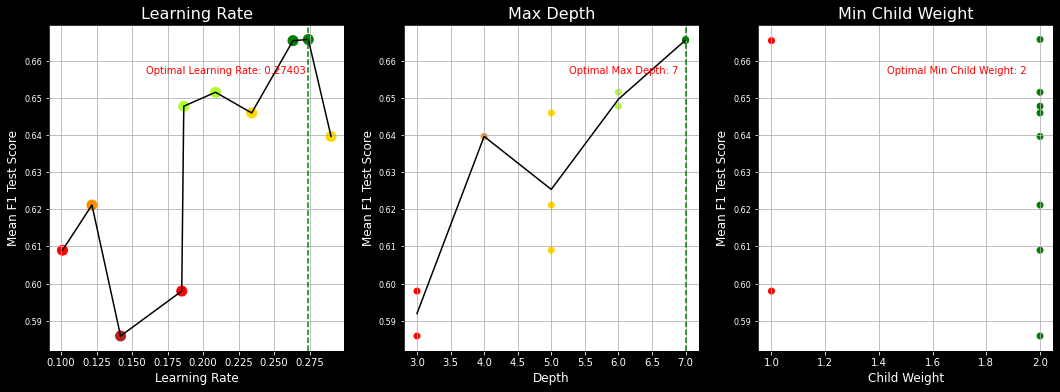

In [129]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6), facecolor = 'black')

df_xgb_results_sorted_lr = df_xgb_results.sort_values(by = 'param_learning_rate')
colors_learning_rate_xgb = ['red', 'darkorange', 'firebrick', 'red', 'greenyellow', 'greenyellow', 'gold', 'green', 'green', 'gold']
opt_learning_rate_xgb = 0.27403
axs[0].scatter(df_xgb_results_sorted_lr['param_learning_rate'], df_xgb_results_sorted_lr['mean_test_score'], marker = 'o', s = 100, color = colors_learning_rate_xgb, zorder = 1)
axs[0].plot(df_xgb_results_sorted_lr['param_learning_rate'], df_xgb_results_sorted_lr['mean_test_score'], color = 'black', zorder = 2)
axs[0].axvline(x = opt_learning_rate_xgb, linestyle = '--', color = 'green')
axs[0].set_title('Learning Rate', color = 'white', fontsize = 16)
axs[0].set_xlabel('Learning Rate', color = 'white', fontsize = 12)
axs[0].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[0].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[0].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[0].grid(True)
axs[0].text(0.272, 0.656, f'Optimal Learning Rate: {opt_learning_rate_xgb}', color = 'red', ha = 'right', va = 'bottom', zorder = 3)

df_xgb_results_sorted_md = df_xgb_results.sort_values(by = 'param_max_depth')
colors_max_depth_xgb = ['red', 'red', 'darkorange', 'gold', 'gold', 'gold', 'greenyellow', 'greenyellow', 'green', 'green']
opt_max_depth_xgb = 7
avg_md = {3: 0.591923, 4: 0.639634, 5: 0.625361, 6: 0.6496545, 7: 0.6656015}
axs[1].scatter(df_xgb_results_sorted_md['param_max_depth'], df_xgb_results_sorted_md['mean_test_score'], color = colors_max_depth_xgb)
axs[1].plot(avg_md.keys(), avg_md.values(), color = 'black')
axs[1].axvline(x = opt_max_depth_xgb, linestyle = '--', color = 'green')
axs[1].set_title('Max Depth', color = 'white', fontsize = 16)
axs[1].set_xlabel('Depth', color = 'white', fontsize = 12)
axs[1].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[1].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[1].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[1].text(6.9, 0.656, f'Optimal Max Depth: {opt_max_depth_xgb}', color = 'red', ha = 'right', va = 'bottom', zorder = 3)
axs[1].grid(True)

df_xgb_results_sorted_mcw = df_xgb_results.sort_values(by = 'param_min_child_weight')
colors_min_child_weight_xgb = ['red', 'red', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']
opt_min_child_weight_xgb = 2
axs[2].scatter(df_xgb_results_sorted_mcw['param_min_child_weight'], df_xgb_results_sorted_mcw['mean_test_score'], color = colors_min_child_weight_xgb)
axs[2].set_title('Min Child Weight', color = 'white', fontsize = 16)
axs[2].set_xlabel('Child Weight', color = 'white', fontsize = 12)
axs[2].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[2].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[2].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[2].text(1.95, 0.656, f'Optimal Min Child Weight: {opt_min_child_weight_xgb}', color = 'red', ha = 'right', va = 'bottom', zorder = 3)
axs[2].grid(True)

plt.savefig('Images/xgb_hyperparamer_tuning_results.png')
plt.show()

#### Random Forest Classifier

The next model I examined was Random Forest Classifier.  This model was is much quicker than a boosting model and may have more interpretable results.  It did pretty well on predictions, but it is very clearly overfit.

In [22]:
start = time.time()

rfc = RandomForestClassifier(random_state = 100)
rfc.fit(X_train_sub, y_train_sub)
evaluate_model(rfc, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.9905601664501414
Weighted F1 Score (Test): 0.7035435218596305
Log Loss (Train):  0.19109601678281762
Log Loss (Test):  0.8009380725751764
Runtime: 1 minute, 11.93 seconds


In [23]:
pickle.dump(rfc, open('Models/randomforest_baseline.pkl', 'wb'))

In [135]:
start = time.time()

rfc_params = {
    'criterion': ['gini'],
    'max_depth': [None, 7, 8, 9, 10],
    'n_estimators':  [100, 200, 300, 400, 500],
    'min_samples_split':  [2, 3, 4, 5],
    'min_samples_leaf':  [1, 2],
}

search_rfc = RandomizedSearchCV(rfc, rfc_params, scoring = 'f1_weighted', n_jobs = 1, random_state = 200)
search_rfc.fit(X_train_sub, y_train_sub)

evaluate_model(search_rfc, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.8385604889630827
Weighted F1 Score (Test): 0.6571059696458239
Log Loss (Train):  0.690418376680256
Log Loss (Test):  0.8923159470582819
Runtime: 25 minutes, 51.62 seconds


In [136]:
best_parameters_rfc = search_rfc.best_params_
print('Randomized Search found the following optimal parameters: ')
for param_name in sorted(best_parameters_rfc.keys()):
    print('%s: %r' % (param_name, best_parameters_rfc[param_name]))
print("")

Randomized Search found the following optimal parameters: 
criterion: 'gini'
max_depth: None
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 300



In [137]:
pickle.dump(search_rfc, open('Models/randomforest_search.pkl', 'wb'))

In [138]:
rfc_results = search_rfc.cv_results_
df_rfc_results = pd.DataFrame(rfc_results)

In [176]:
df_rfc_results_sorted_est

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,6.732989,0.435415,0.088491,0.007265,100,3,1,9,gini,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.453545,0.448898,0.457999,0.439104,0.453825,0.450674,0.006463,8
7,6.388730,0.131007,0.088898,0.003706,100,4,1,9,gini,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.454021,0.449870,0.461825,0.441026,0.463537,0.454056,0.008217,5
0,12.738151,0.463922,0.148031,0.027065,200,2,1,9,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.450227,0.448159,0.456772,0.444031,0.468658,0.453569,0.008595,6
4,36.554266,0.925941,0.367730,0.085381,200,5,2,None,gini,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.649443,0.638216,0.636114,0.633838,0.632280,0.637978,0.006076,2
8,13.106792,0.552139,0.143569,0.014573,200,2,2,9,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.445895,0.445215,0.454143,0.436408,0.454465,0.447225,0.006680,9
6,57.519620,1.468206,0.468200,0.027219,300,2,2,None,gini,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.649774,0.640381,0.641611,0.628188,0.631892,0.638369,0.007619,1
1,62.668085,57.900618,0.265276,0.012255,500,3,1,10,gini,"{'n_estimators': 500, 'min_samples_split': 3, ...",0.464810,0.460600,0.462163,0.455479,0.463477,0.461306,0.003230,3
2,34.729358,2.465991,0.266497,0.007858,500,4,2,10,gini,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.463111,0.455227,0.456797,0.447911,0.457997,0.456209,0.004919,4
5,28.039471,1.163817,0.265420,0.052676,500,4,1,8,gini,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.440699,0.437453,0.448405,0.432877,0.443306,0.440548,0.005250,10
9,32.234004,1.485450,0.278158,0.011702,500,2,1,9,gini,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.449536,0.449374,0.457367,0.443508,0.458322,0.451621,0.005534,7


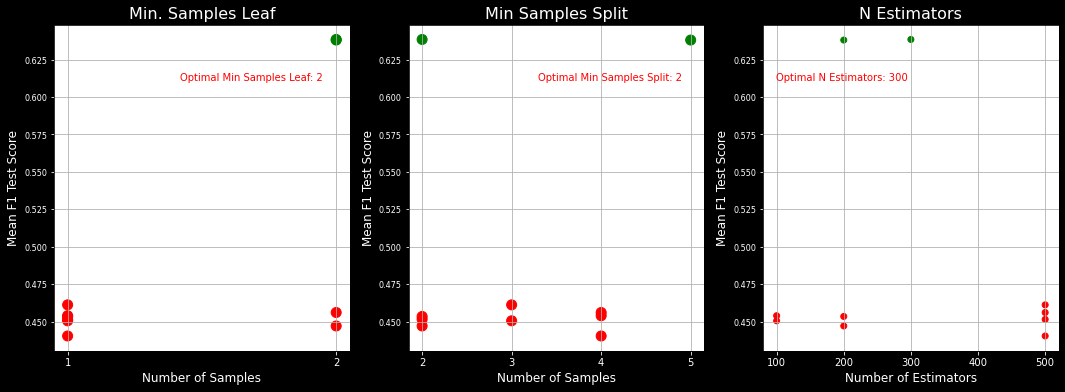

In [178]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6), facecolor = 'black')

df_rfc_results_sorted_msl = df_rfc_results.sort_values(by = 'param_min_samples_leaf')
colors_msl_rfc = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'red']
axs[0].scatter(df_rfc_results_sorted_msl['param_min_samples_leaf'], df_rfc_results_sorted_msl['mean_test_score'], marker = 'o', s = 100, color = colors_msl_rfc)
axs[0].set_title('Min. Samples Leaf', color = 'white', fontsize = 16)
axs[0].set_xlabel('Number of Samples', color = 'white', fontsize = 12)
axs[0].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[0].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[0].set_xticks([1, 2])
axs[0].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[0].grid(True)
axs[0].text(1.95, 0.61, 'Optimal Min Samples Leaf: 2', color = 'red', ha = 'right', va = 'bottom')

df_rfc_results_sorted_mss = df_rfc_results.sort_values(by = 'param_min_samples_split')
colors_mss_rfc = ['red', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green']
axs[1].scatter(df_rfc_results_sorted_mss['param_min_samples_split'], df_rfc_results_sorted_mss['mean_test_score'], marker = 'o', s = 100, color = colors_mss_rfc)
axs[1].set_title('Min Samples Split', color = 'white', fontsize = 16)
axs[1].set_xlabel('Number of Samples', color = 'white', fontsize = 12)
axs[1].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[1].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[1].set_xticks([2, 3, 4, 5])
axs[1].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[1].text(4.9, 0.61, 'Optimal Min Samples Split: 2', color = 'red', ha = 'right', va = 'bottom', zorder = 3)
axs[1].grid(True)

df_rfc_results_sorted_est = df_rfc_results.sort_values(by = 'param_n_estimators')
colors_est_rfc = ['red', 'red', 'red', 'green', 'red', 'green', 'red', 'red', 'red', 'red']
axs[2].scatter(df_rfc_results_sorted_est['param_n_estimators'], df_rfc_results_sorted_est['mean_test_score'], color = colors_est_rfc)
axs[2].set_title('N Estimators', color = 'white', fontsize = 16)
axs[2].set_xlabel('Number of Estimators', color = 'white', fontsize = 12)
axs[2].set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
axs[2].tick_params(axis = 'x', colors = 'white', labelsize = 10)
axs[2].tick_params(axis = 'y', colors = 'white', labelsize = 8)
axs[2].set_xticks([100, 200, 300, 400, 500])
axs[2].text(295, 0.61, 'Optimal N Estimators: 300', color = 'red', ha = 'right', va = 'bottom', zorder = 3)
axs[2].grid(True)

plt.savefig('Images/rfc_hyperparamer_tuning_results.png')
plt.show()

#### Extra Trees Classifier

Lastly, I examined Extra Trees Classifier.  This model performed the best 

In [31]:
start = time.time()

etc = ExtraTreesClassifier(n_estimators = 200, random_state = 100)
etc.fit(X_train_sub, y_train_sub)
evaluate_model(etc, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7223744445188811
Log Loss (Train):  0.014785287311012446
Log Loss (Test):  1.1654479598854746
Runtime: 6 minutes, 8.36 seconds


In [32]:
pickle.dump(etc, open('Models/extratrees_baseline.pkl', 'wb'))

In [33]:
etc_estimators = [100, 200, 300, 400, 500]
for value in etc_estimators:
    start = time.time()

    etc = ExtraTreesClassifier(n_estimators = value, random_state = 100)
    etc.fit(X_train_sub, y_train_sub)
    print(f"n_estimators = {value}")
    print("===============================")
    evaluate_model(etc, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

    end = time.time()
    runtime(start, end)

n_estimators = 100
Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7203912696879069
Log Loss (Train):  0.014785287311012446
Log Loss (Test):  1.196694260969227
Runtime: 3 minutes, 5.50 seconds
n_estimators = 200
Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7223744445188811
Log Loss (Train):  0.014785287311012446
Log Loss (Test):  1.1654479598854746
Runtime: 6 minutes, 6.35 seconds
n_estimators = 300
Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7232537409404399
Log Loss (Train):  0.014785287311012446
Log Loss (Test):  1.1584679640903943
Runtime: 9 minutes, 18.14 seconds
n_estimators = 400
Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7235271508221869
Log Loss (Train):  0.014785287311012446
Log Loss (Test):  1.1503314681477887
Runtime: 12 minutes, 17.91 seconds
n_estimators = 500
Weighted F1 Score (Train): 0.990562519914399
Weighted F1 Score (Test): 0.7217009873284578
Log Loss (Tra

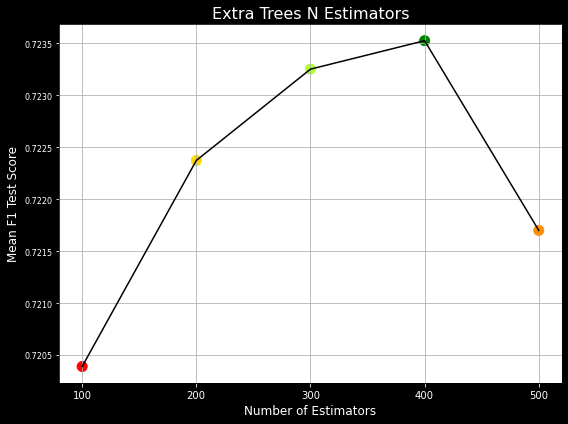

In [188]:
etc_estimators = [100, 200, 300, 400, 500]
etc_estimators_score = [0.720391, 0.722374, 0.723253, 0.723527, 0.721701]

fig, ax = plt.subplots(figsize = (8, 6), facecolor = 'black')
colors_etc = ['red', 'gold', 'greenyellow', 'green', 'darkorange']
ax.scatter(etc_estimators, etc_estimators_score, marker = 'o', s = 100, color = colors_etc)
ax.plot(etc_estimators, etc_estimators_score, color = 'black')
ax.set_title('Extra Trees N Estimators', color = 'white', fontsize = 16)
ax.set_xlabel('Number of Estimators', color = 'white', fontsize = 12)
ax.set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
ax.tick_params(axis = 'x', colors = 'white', labelsize = 10)
ax.set_xticks([100, 200, 300, 400, 500])
ax.tick_params(axis = 'y', colors = 'white', labelsize = 8)
ax.grid(True)

plt.savefig('Images/extra_trees_estimator_tuning.png')
plt.tight_layout()
plt.show()

#### Conclusion

Model Selection - Amongst those I tested, XGBoost, Random Forest Classifier, and Extra Trees Classifier were the 3 models that performed the best and are the ones I will be using in the final notebook.

Hyperparameters - I found the following optimal parameter values for each of these models:

Next Steps - In the final notebook, I will be combining these models together using either a Voting Classifier or a Stacking method to obtain the best possible results.  I will also run the above models using the full data set.